In [1]:
!nvidia-smi

Sun Mar 31 12:52:35 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 537.58                 Driver Version: 537.58       CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                     TCC/WDDM  | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce GTX 1650      WDDM  | 00000000:01:00.0 Off |                  N/A |
| N/A   49C    P8               3W /  50W |      0MiB /  4096MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
%pip install pandas
%pip install torch
%pip install seaborn
%pip install lightning
%pip install accelerate 
%pip install numpy
%pip install termcolor
%pip install -U scikit-learn
%pip install transformers
%pip install matplotlib

In [2]:
import json
import numpy as np
import torch
from pathlib import Path 
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger
from sklearn.model_selection import train_test_split

from termcolor import colored
import textwrap
from transformers import(AdamW,T5ForConditionalGeneration,T5TokenizerFast as T5Tokenizer)
from tqdm.auto import tqdm

from torch.utils.data import DataLoader,Dataset

d:\Mini Project\TDD\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
%matplotlib inline
%config InlineBackend.figure_format='retina'
sns.set(style='whitegrid',palette='muted',font_scale=1.2)
rcParams['figure.figsize']=16,10

C:\Users\bOct0\AppData\Local\Temp\ipykernel_21128\1290628736.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [4]:
df = pd.read_excel('final.xlsx')

In [5]:
df.head()

,User Story,Description,Input,Expected Output
0,I want to have the 12-19-2017 deletions proce...,: Process the deletion of a single record.,: Record ID: 12345,: Record 12345 is deleted from the database.
1,I want to have the 12-19-2017 deletions proce...,: Process the deletion of multiple records.,": Record IDs: 12345, 67890, 98765",": Records 12345, 67890, and 98765 are del..."
2,I want to have the 12-19-2017 deletions proce...,: Process the deletion of a record with child ...,: Record ID: 12345 Child Record IDs:...,: Record 12345 and its child records (543...
3,I want to have the 12-19-2017 deletions proce...,: Process the deletion of a record that is ref...,: Record ID: 12345 Referencing Recor...,: Record 12345 cannot be deleted because ...
4,I want to have the 12-19-2017 deletions proce...,: Process the deletion of a record that does n...,: Record ID: 99999,: Record 99999 does not exist in the data...


Taking only the user story and description column

In [6]:
df=df[["User Story","Description"]]
df = df.dropna()
df.head()

,User Story,Description
0,I want to have the 12-19-2017 deletions proce...,: Process the deletion of a single record.
1,I want to have the 12-19-2017 deletions proce...,: Process the deletion of multiple records.
2,I want to have the 12-19-2017 deletions proce...,: Process the deletion of a record with child ...
3,I want to have the 12-19-2017 deletions proce...,: Process the deletion of a record that is ref...
4,I want to have the 12-19-2017 deletions proce...,: Process the deletion of a record that does n...


In [7]:
train_df,test_df = train_test_split(df,test_size=0.1)
train_df.shape,test_df.shape 

((7351, 2), (817, 2))

In [8]:
class TestDataset(Dataset):
    
    def __init__(
        self,
        data:pd.DataFrame,
        tokenizer:T5Tokenizer,
        userstory_max_token_len:int=512,
        description_max_token_len:int=200
    ):
        self.tokenizer = tokenizer
        self.data = data
        self.userstory_max_token_len = userstory_max_token_len
        self.description_max_token_len = description_max_token_len
        
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self,index:int):
        data_row = self.data.iloc[index]
        userstory = data_row["User Story"]
        userstory_encoding = tokenizer(
            userstory,
            max_length = self.userstory_max_token_len,
            padding = "max_length",
            truncation = True,
            return_attention_mask = True,
            add_special_tokens = True,
            return_tensors = "pt"
        )
        description_encoding = tokenizer(
            data_row["description"],
            max_length = self.description_max_token_len,
            padding = "max_length",
            truncation = True,
            return_attention_mask = True,
            add_special_tokens = True,
            return_tensors = "pt"
        )
        
        labels = description_encoding["input_ids"]
        labels[labels==0] = -100
        
        return dict(
            userstory = userstory,
            description = data_row["Description"],
            userstory_input_ids = userstory_encoding["input_ids"].flatten(),
            userstory_attention_mask = userstory_encoding["attention_mask"].flatten(),
            labels=labels.flatten(),
            labels_attention_mask = description_encoding["attention_mask"].flatten(),
        )

In [9]:
class TestDatasetModule(pl.LightningDataModule):
    def __init__(self,
                 train_df:pd.DataFrame,
                 test_df:pd.DataFrame,
                 tokenizer:T5Tokenizer,
                 batch_size:int=8,
                 userstory_max_token_len:int=512,
                 description_max_token_len:int=200):
        super().__init__()
        self.train_df = train_df
        self.test_df=test_df
        self.batch_size = batch_size
        self.tokenizer = tokenizer
        self.userstory_max_token_len = userstory_max_token_len
        self.description_max_token_len = description_max_token_len
    
    def setup(self, stage=None):
        self.train_dataset = TestDataset(
            self.train_df,
            self.tokenizer,
            self.userstory_max_token_len,
            self.description_max_token_len
        )
        self.test_dataset = TestDataset(
            self.test_df,
            self.tokenizer,
            self.userstory_max_token_len,
            self.description_max_token_len
        )
        
    def train_dataloader(self):
        return DataLoader(
            self.train_dataset,
            batch_size=self.batch_size,
            shuffle=True,
            num_workers =2
        )
    def val_dataloader(self):
        return DataLoader(
            self.test_dataset,
            batch_size=self.batch_size,
            shuffle=False,
            num_workers =2
        )
    def test_dataloader(self):
        return DataLoader(
            self.train_dataset,
            batch_size=self.batch_size,
            shuffle=False,
            num_workers =2
        )
        

In [10]:
MODEL_NAME = "t5-base"
tokenizer = T5Tokenizer.from_pretrained(MODEL_NAME)

In [11]:
userstory_token_counts,description_token_counts = [],[]
for _,row in train_df.iterrows():
    userstory_token_count = len(tokenizer.encode(row["User Story"]))
    userstory_token_counts.append(userstory_token_count)
    
    description_token_count = len(tokenizer.encode(row["Description"]))
    description_token_counts.append(description_token_count)

Text(0.5, 1.0, 'Description token count')

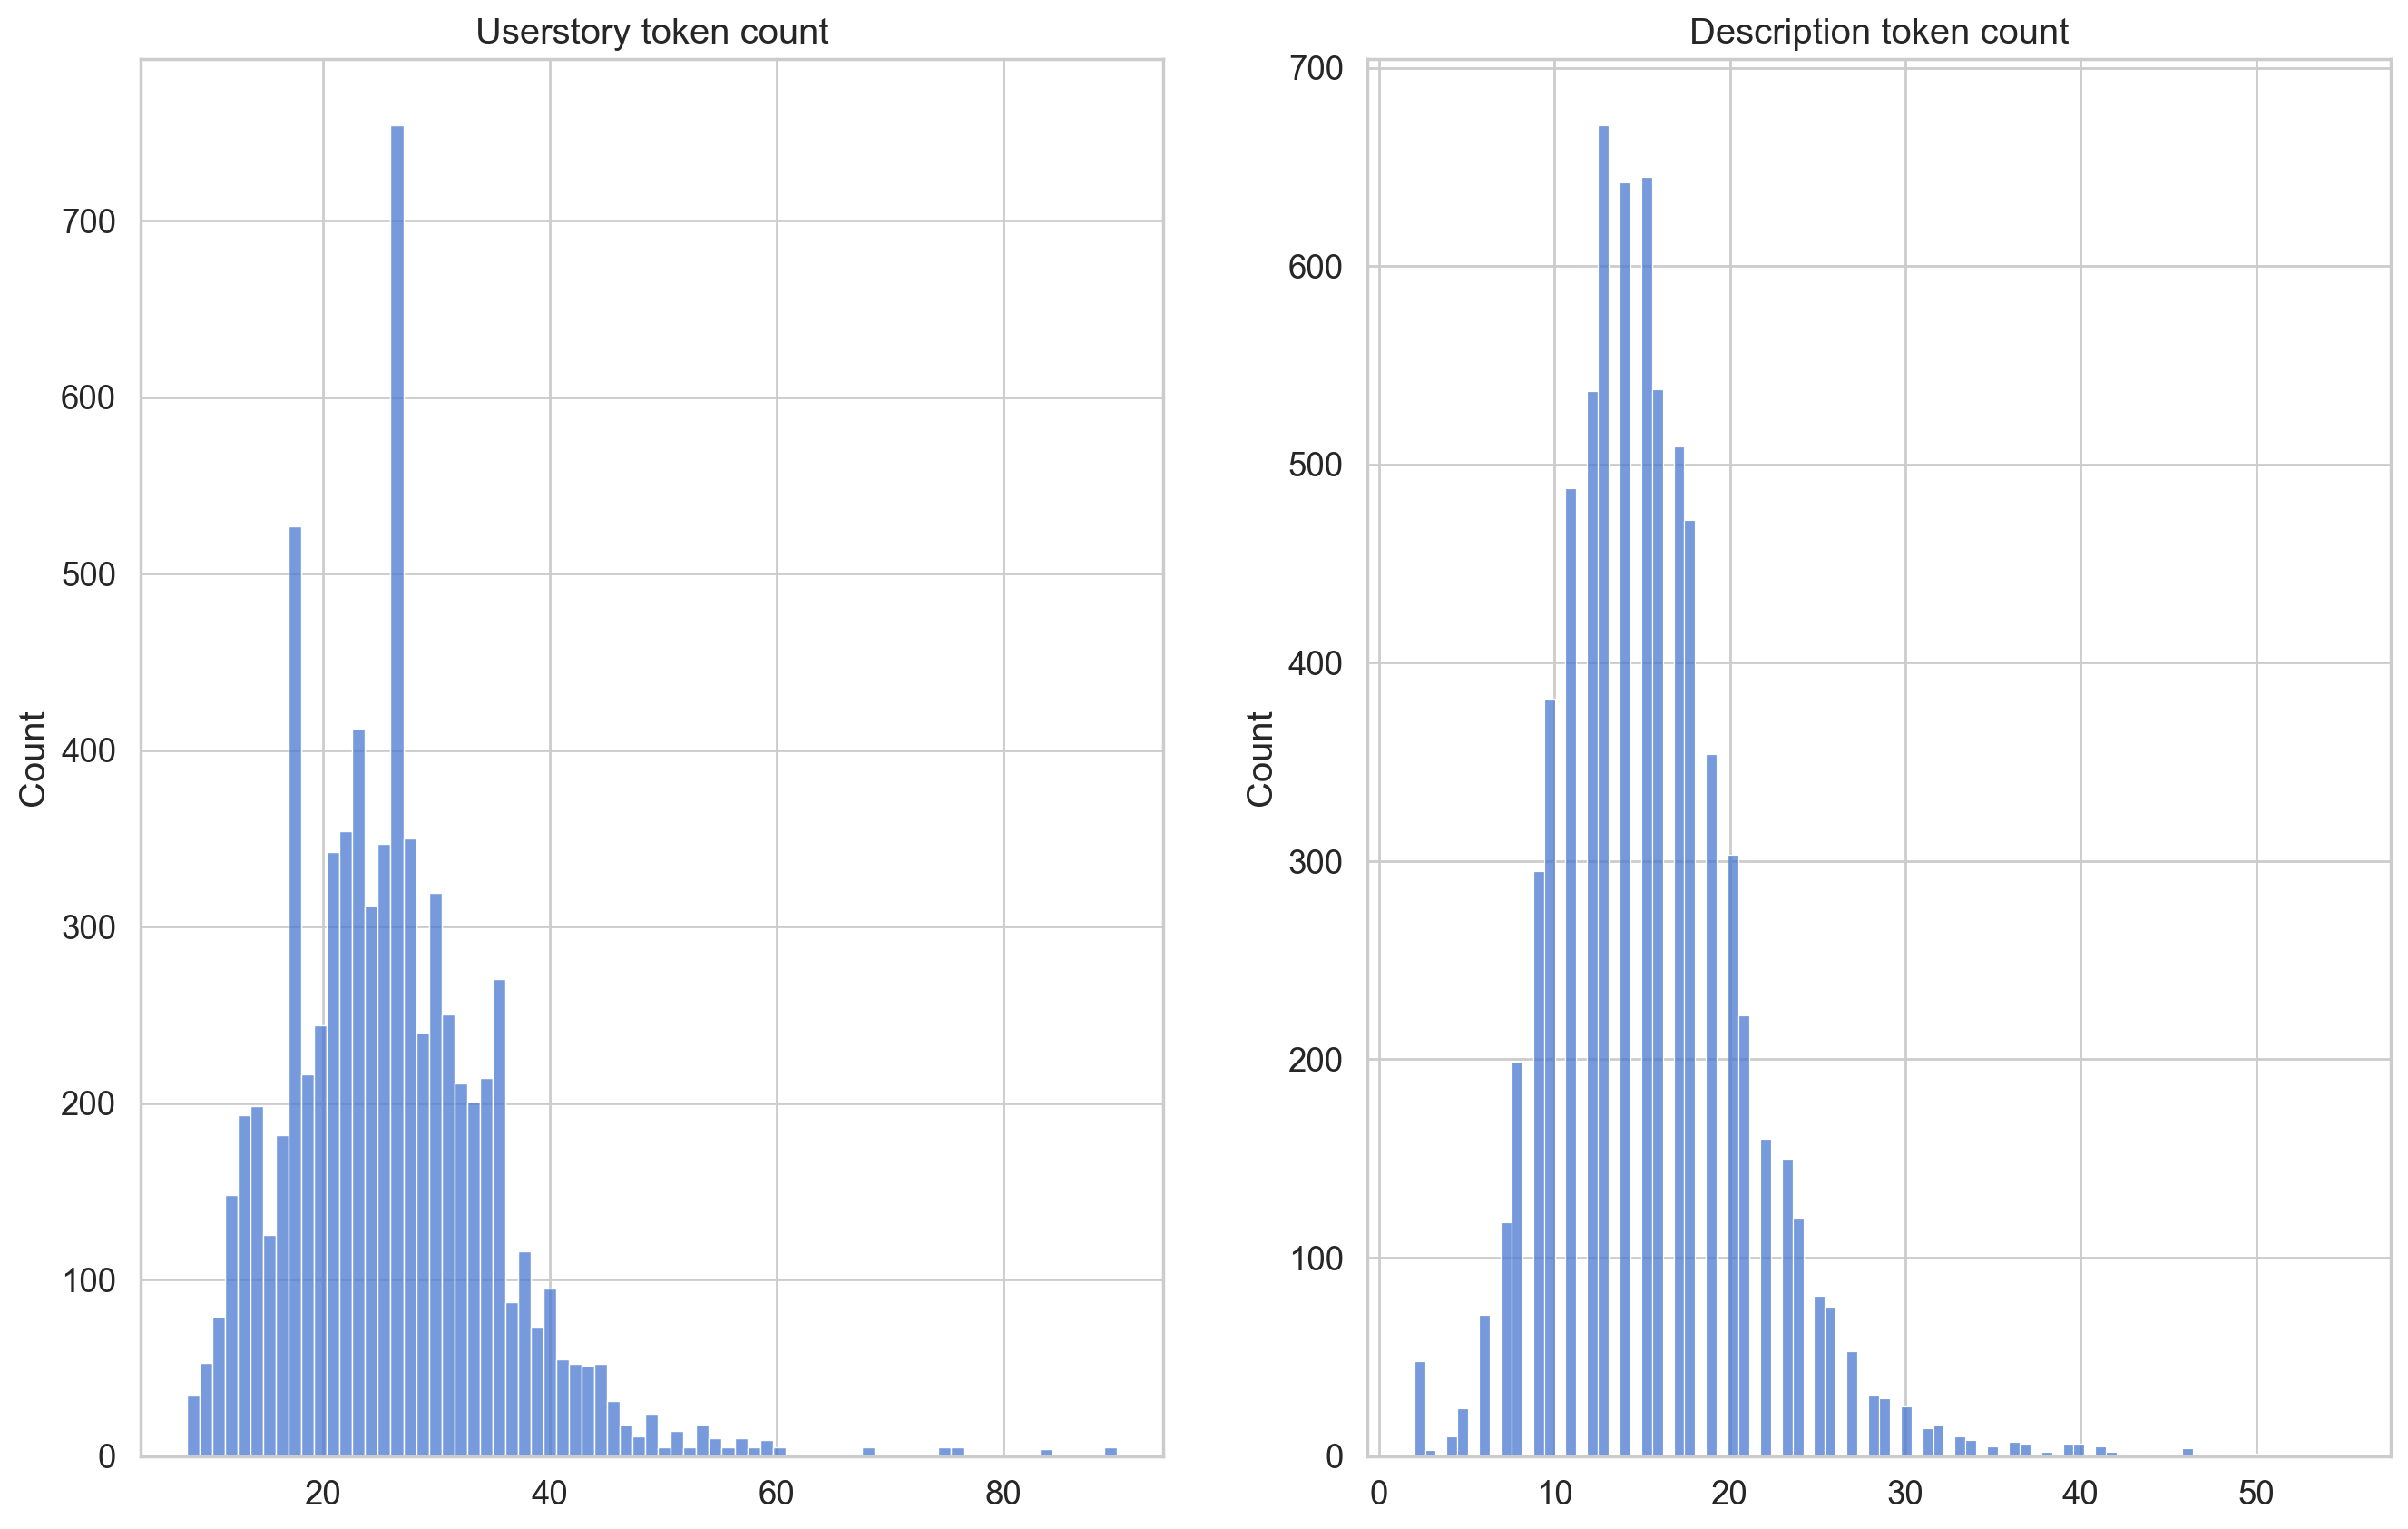

In [12]:
fig,(ax1,ax2) = plt.subplots(1,2)
sns.histplot(userstory_token_counts,ax = ax1)
ax1.set_title("Userstory token count")
sns.histplot(description_token_counts,ax = ax2)
ax2.set_title("Description token count")

In [13]:
N_EPOCHS = 3
BATCH_SIZE = 8
data_module = TestDatasetModule(train_df,test_df,tokenizer,batch_size=BATCH_SIZE)

Model

In [14]:
class TestDataModel(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.model = T5ForConditionalGeneration.from_pretrained(MODEL_NAME,return_dict=True)
    
    def forward(self,input_ids,attention_mask,decoder_attention_mask,labels=None):
        output = self.model(
            input_ids,
            attention_mask = attention_mask,
            labels= labels,
            decoder_attention_mask = decoder_attention_mask
        )
        return output.loss,output.logits
    
    def training_step(self,batch,batch_idx):
        input_ids = batch["userstory_input_ids"]
        attention_mask = batch["userstory_attention_mask"]
        labels = batch["labels"]
        labels_attention_mask =batch["labels_attention_mask"]
        loss,outputs= self(
            input_ids=input_ids,
            attention_mask= attention_mask,
            decoder_attention_mask= labels_attention_mask,
            labels=labels
        )
        self.log("train_loss",loss,prog_bar=True,logger=True)
        return loss
    
    def validation_step(self,batch,batch_idx):
        input_ids = batch["userstory_input_ids"]
        attention_mask = batch["userstory_attention_mask"]
        labels = batch["labels"]
        labels_attention_mask =batch["labels_attention_mask"]
        loss,outputs= self(
            input_ids=input_ids,
            attention_mask= attention_mask,
            decoder_attention_mask= labels_attention_mask,
            labels=labels
        )
        self.log("val_loss",loss,prog_bar=True,logger=True)
        return loss
    
    def test_step(self,batch,batch_idx):
        input_ids = batch["userstory_input_ids"]
        attention_mask = batch["userstory_attention_mask"]
        labels = batch["labels"]
        labels_attention_mask =batch["labels_attention_mask"]
        loss,outputs= self(
            input_ids=input_ids,
            attention_mask= attention_mask,
            decoder_attention_mask= labels_attention_mask,
            labels=labels
        )
        self.log("test_loss",loss,prog_bar=True,logger=True)
        return loss
    
    def configure_optimizers(self):
        return AdamW(self.parameters(),lr=0.0001)

In [15]:
model = TestDataModel()

In [17]:
%load_ext tensorboard
%tensorboard --logdir ./lightning_logs

Reusing TensorBoard on port 6006 (pid 25212), started 0:23:10 ago. (Use '!kill 25212' to kill it.)

In [18]:
checkpoint_callback = ModelCheckpoint(
    dirpath = "checkpoints",
    filename = "best-checkpoint",
    save_top_k =1,
    verbose = True,
    monitor = "val_loss",
    mode = "min"
)
logger = TensorBoardLogger("lightning_logs",name="test-case-data")
trainer = pl.Trainer(
    logger = logger,
    callbacks = checkpoint_callback,
    max_epochs=N_EPOCHS,
    # gpus = 1,
    # progress_bar_refresh_rate = 30
)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [19]:
trainer.fit(model,data_module)

d:\Mini Project\TDD\venv\Lib\site-packages\transformers\optimization.py:457: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(

  | Name  | Type                       | Params
-----------------------------------------------------
0 | model | T5ForConditionalGeneration | 222 M 
-----------------------------------------------------
222 M     Trainable params
0         Non-trainable params
222 M     Total params
891.614   Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

d:\Mini Project\TDD\venv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:436: Consider setting `persistent_workers=True` in 'val_dataloader' to speed up the dataloader worker initialization.
